In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
import nltk
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from sklearn.model_selection import train_test_split

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame({
    'Text': newsgroups.data,
    'Category': newsgroups.target
})
df['Category Name'] = df['Category'].apply(lambda x: newsgroups.target_names[x])
df

# Lowercasing
df['Text'] = df['Text'].str.lower()

# Remove Punctuation and special characters
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenization
df['Tokens'] = df['Text'].apply(word_tokenize)

# Removing Stopwords
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Tokens'] = df['Tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['Text'])
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

from tensorflow.keras.utils import to_categorical
y = to_categorical(df['Category'])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

# Model with Unidirectional LSTM
model_uni = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length),
    LSTM(128),
    Dense(len(newsgroups.target_names), activation='softmax')
])

# Model with Bidirectional LSTM
model_bi = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length),
    Bidirectional(LSTM(128)),
    Dense(len(newsgroups.target_names), activation='softmax')
])

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Compile both models
for model in [model_uni, model_bi]:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Unidirectional LSTM model
history_uni = model_uni.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)

# Train Bidirectional LSTM model
history_bi = model_bi.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 177s 365ms/step - accuracy: 0.0537 - loss: 2.9953 - val_accuracy: 0.0525 - val_loss: 2.9947
Epoch 2/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 173s 367ms/step - accuracy: 0.0491 - loss: 2.9920 - val_accuracy: 0.0446 - val_loss: 2.9936
Epoch 3/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 173s 367ms/step - accuracy: 0.0516 - loss: 2.9925 - val_accuracy: 0.0485 - val_loss: 2.9924
Epoch 4/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 173s 367ms/step - accuracy: 0.0510 - loss: 2.9907 - val_accuracy: 0.0446 - val_loss: 2.9932
Epoch 5/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 173s 367ms/step - accuracy: 0.0553 - loss: 2.9906 - val_accuracy: 0.0485 - val_loss: 2.9930
Epoch 1/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 341s 717ms/step - accuracy: 0.0959 - loss: 2.8497 - val_accuracy: 0.1891 - val_loss: 2.3746
Epoch 2/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 338s 717ms/step - accuracy: 0.2775 - loss: 2.1159 - val_accuracy: 0.3146 - val_loss: 1.9637
Epoch 3/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 338s 717ms/step - accuracy: 0.4286 - loss: 1

In [2]:
# Extract and store the training history
train_uni_loss = history_uni.history['loss']
val_uni_loss = history_uni.history['val_loss']
train_uni_accuracy = history_uni.history['accuracy']
val_uni_accuracy = history_uni.history['val_accuracy']


In [3]:
# Extract and store the training history
train_bi_loss = history_bi.history['loss']
val_bi_loss = history_bi.history['val_loss']
train_bi_accuracy = history_bi.history['accuracy']
val_bi_accuracy = history_bi.history['val_accuracy']


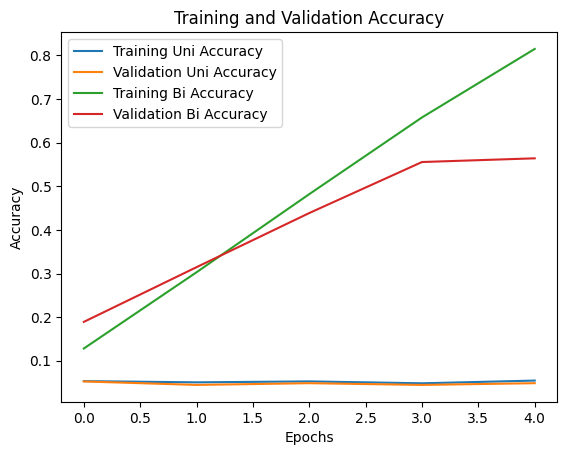

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_uni_accuracy, label='Training Uni Accuracy')
plt.plot(val_uni_accuracy, label='Validation Uni Accuracy')
plt.plot(train_bi_accuracy, label='Training Bi Accuracy')
plt.plot(val_bi_accuracy, label='Validation Bi Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [5]:
test_uni_loss, test_uni_accuracy = model_uni.evaluate(x_test, y_test)
print(f"Test Uni Loss: {test_uni_loss}")
print(f"Test Uni Accuracy: {test_uni_accuracy}")

test_bi_loss, test_bi_accuracy = model_bi.evaluate(x_test, y_test)
print(f"Test Bi Loss: {test_bi_loss}")
print(f"Test Bi Accuracy: {test_bi_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.0481 - loss: 2.9945
Test Uni Loss: 2.9929842948913574
Test Uni Accuracy: 0.0485411137342453
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 261ms/step - accuracy: 0.5472 - loss: 1.6016
Test Bi Loss: 1.5390866994857788
Test Bi Accuracy: 0.5641909837722778
